In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install unzip

In [5]:
!unzip "xview_recognition.zip"

"unzip" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [6]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [7]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [8]:
!pip install rasterio

In [9]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [11]:
import json
# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [12]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [13]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)


In [14]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def create_model(n_neurons):
    print('Load model')
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))


    model.add(Flatten())

    model.add(Dense(256, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    model.add(Dense(128, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    model.add(Dense(n_neurons, activation='softmax'))


    # Print model summary
    model.summary()

    opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
import math
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

epochs = 40
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)



In [16]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=10, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=model.hdf5

In [14]:
model = create_model(12)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Load model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 127s 180ms/step - loss: 2.5127 - accuracy: 0.3988 - val_loss: 2.1345 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 2/40
602/602 [==============================] - ETA: 0s - loss: 1.9393 - accuracy: 0.5456
Epoch 2: val_accuracy improved from 0.49111 to 0.54443, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 103s 172ms/step - loss: 1.9393 - accuracy: 0.5456 - val_loss: 1.8886 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 3/40
601/602 [============================>.] - ETA: 0s - loss: 1.7729 - accuracy: 0.5841
Epoch 3: val_accuracy improved from 0.54443 to 0.60898, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 102s 169ms/step - loss: 1.7729 - accuracy: 0.5841 - val_loss: 1.6558 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 4/40
602/602 [==============================] - ETA: 0s - loss: 1.6735 - accuracy: 0.6006
Epoch 4: val_accuracy did not improve from 0.60898
602/602 [==============================] - 101s 168ms/step - loss: 1.6735 - accuracy: 0.6006 - val_loss: 1.6585 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 5/40
601/602 [============================>.] - ETA: 0s - loss: 1.6118 - accuracy: 0.6111
Epoch 5: val_accuracy improved from 0.60898 to 0.62301, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 98s 164ms/step - loss: 1.6117 - accuracy: 0.6111 - val_loss: 1.5985 - val_accuracy: 0.6230 - lr: 0.0010
Epoch 6/40
601/602 [============================>.] - ETA: 0s - loss: 1.5714 - accuracy: 0.6207
Epoch 6: val_accuracy improved from 0.62301 to 0.64032, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 101s 168ms/step - loss: 1.5716 - accuracy: 0.6207 - val_loss: 1.4992 - val_accuracy: 0.6403 - lr: 0.0010
Epoch 7/40
601/602 [============================>.] - ETA: 0s - loss: 1.5366 - accuracy: 0.6308
Epoch 7: val_accuracy did not improve from 0.64032
602/602 [==============================] - 100s 166ms/step - loss: 1.5367 - accuracy: 0.6308 - val_loss: 1.6145 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 8/40
602/602 [==============================] - ETA: 0s - loss: 1.5150 - accuracy: 0.6400
Epoch 8: val_accuracy improved from 0.64032 to 0.65388, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 102s 169ms/step - loss: 1.5150 - accuracy: 0.6400 - val_loss: 1.4821 - val_accuracy: 0.6539 - lr: 0.0010
Epoch 9/40
601/602 [============================>.] - ETA: 0s - loss: 1.4754 - accuracy: 0.6524
Epoch 9: val_accuracy did not improve from 0.65388
602/602 [==============================] - 100s 166ms/step - loss: 1.4753 - accuracy: 0.6524 - val_loss: 1.6078 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 10/40
601/602 [============================>.] - ETA: 0s - loss: 1.4821 - accuracy: 0.6542
Epoch 10: val_accuracy did not improve from 0.65388
602/602 [==============================] - 101s 168ms/step - loss: 1.4819 - accuracy: 0.6542 - val_loss: 1.5261 - val_accuracy: 0.6394 - lr: 0.0010
Epoch 11/40
602/602 [==============================] - ETA: 0s - loss: 1.4578 - accuracy: 0.6632
Epoch 11: val_accuracy improved from 0.65388 to 0.65856, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 101s 169ms/step - loss: 1.4578 - accuracy: 0.6632 - val_loss: 1.4906 - val_accuracy: 0.6586 - lr: 0.0010
Epoch 12/40
601/602 [============================>.] - ETA: 0s - loss: 1.4410 - accuracy: 0.6711
Epoch 12: val_accuracy did not improve from 0.65856
602/602 [==============================] - 99s 165ms/step - loss: 1.4412 - accuracy: 0.6711 - val_loss: 1.6405 - val_accuracy: 0.5987 - lr: 0.0010
Epoch 13/40
602/602 [==============================] - ETA: 0s - loss: 1.4281 - accuracy: 0.6719
Epoch 13: val_accuracy did not improve from 0.65856
602/602 [==============================] - 102s 169ms/step - loss: 1.4281 - accuracy: 0.6719 - val_loss: 1.5779 - val_accuracy: 0.6342 - lr: 0.0010
Epoch 14/40
601/602 [============================>.] - ETA: 0s - loss: 1.4144 - accuracy: 0.6765
Epoch 14: val_accuracy did not improve from 0.65856
602/602 [==============================] - 101s 168ms/step - loss: 1.4143 - accuracy: 0.6765 - val_loss: 1.579

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 102s 169ms/step - loss: 1.3999 - accuracy: 0.6847 - val_loss: 1.4371 - val_accuracy: 0.6665 - lr: 0.0010
Epoch 16/40
601/602 [============================>.] - ETA: 0s - loss: 1.3935 - accuracy: 0.6894
Epoch 16: val_accuracy improved from 0.66651 to 0.68428, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 100s 165ms/step - loss: 1.3938 - accuracy: 0.6893 - val_loss: 1.4185 - val_accuracy: 0.6843 - lr: 0.0010
Epoch 17/40
601/602 [============================>.] - ETA: 0s - loss: 1.3805 - accuracy: 0.6954
Epoch 17: val_accuracy improved from 0.68428 to 0.69270, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 102s 169ms/step - loss: 1.3805 - accuracy: 0.6954 - val_loss: 1.3873 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 18/40
602/602 [==============================] - ETA: 0s - loss: 1.3836 - accuracy: 0.6998
Epoch 18: val_accuracy did not improve from 0.69270
602/602 [==============================] - 99s 164ms/step - loss: 1.3836 - accuracy: 0.6998 - val_loss: 1.5671 - val_accuracy: 0.6478 - lr: 0.0010
Epoch 19/40
601/602 [============================>.] - ETA: 0s - loss: 1.3658 - accuracy: 0.7066
Epoch 19: val_accuracy did not improve from 0.69270
602/602 [==============================] - 102s 169ms/step - loss: 1.3661 - accuracy: 0.7065 - val_loss: 1.5170 - val_accuracy: 0.6553 - lr: 0.0010
Epoch 20/40
601/602 [============================>.] - ETA: 0s - loss: 1.3592 - accuracy: 0.7086
Epoch 20: val_accuracy did not improve from 0.69270
602/602 [==============================] - 101s 168ms/step - loss: 1.3594 - accuracy: 0.7086 - val_loss: 1.452

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 100s 166ms/step - loss: 1.1483 - accuracy: 0.7729 - val_loss: 1.2039 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 24/40
601/602 [============================>.] - ETA: 0s - loss: 1.0121 - accuracy: 0.7922
Epoch 24: val_accuracy improved from 0.74228 to 0.75210, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 100s 166ms/step - loss: 1.0120 - accuracy: 0.7922 - val_loss: 1.1191 - val_accuracy: 0.7521 - lr: 1.0000e-04
Epoch 25/40
601/602 [============================>.] - ETA: 0s - loss: 0.9077 - accuracy: 0.8087
Epoch 25: val_accuracy did not improve from 0.75210
602/602 [==============================] - 102s 169ms/step - loss: 0.9082 - accuracy: 0.8085 - val_loss: 1.0668 - val_accuracy: 0.7512 - lr: 1.0000e-04
Epoch 26/40
601/602 [============================>.] - ETA: 0s - loss: 0.8417 - accuracy: 0.8204
Epoch 26: val_accuracy improved from 0.75210 to 0.75257, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 102s 170ms/step - loss: 0.8417 - accuracy: 0.8204 - val_loss: 1.0455 - val_accuracy: 0.7526 - lr: 1.0000e-04
Epoch 27/40
601/602 [============================>.] - ETA: 0s - loss: 0.7846 - accuracy: 0.8321
Epoch 27: val_accuracy improved from 0.75257 to 0.75585, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 102s 169ms/step - loss: 0.7844 - accuracy: 0.8321 - val_loss: 1.0115 - val_accuracy: 0.7558 - lr: 1.0000e-04
Epoch 28/40
602/602 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.8403
Epoch 28: val_accuracy did not improve from 0.75585
602/602 [==============================] - 102s 169ms/step - loss: 0.7422 - accuracy: 0.8403 - val_loss: 1.0134 - val_accuracy: 0.7507 - lr: 1.0000e-04
Epoch 29/40
601/602 [============================>.] - ETA: 0s - loss: 0.7065 - accuracy: 0.8448
Epoch 29: val_accuracy did not improve from 0.75585
602/602 [==============================] - 100s 166ms/step - loss: 0.7065 - accuracy: 0.8447 - val_loss: 1.0071 - val_accuracy: 0.7516 - lr: 1.0000e-04
Epoch 30/40
601/602 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.8542
Epoch 30: val_accuracy did not improve from 0.75585
602/602 [==============================] - 99s 165ms/step - loss: 0.6779 - accuracy: 0.8542 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 102s 170ms/step - loss: 0.6167 - accuracy: 0.8711 - val_loss: 0.9866 - val_accuracy: 0.7601 - lr: 1.0000e-04
Epoch 33/40
601/602 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.8745
Epoch 33: val_accuracy did not improve from 0.76006
602/602 [==============================] - 99s 165ms/step - loss: 0.5950 - accuracy: 0.8745 - val_loss: 0.9823 - val_accuracy: 0.7535 - lr: 1.0000e-04
Epoch 34/40
601/602 [============================>.] - ETA: 0s - loss: 0.5736 - accuracy: 0.8823
Epoch 34: val_accuracy did not improve from 0.76006
602/602 [==============================] - 101s 168ms/step - loss: 0.5737 - accuracy: 0.8823 - val_loss: 0.9957 - val_accuracy: 0.7521 - lr: 1.0000e-04
Epoch 35/40
602/602 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.8872
Epoch 35: val_accuracy did not improve from 0.76006
602/602 [==============================] - 101s 168ms/step - loss: 0.5527 - accuracy: 0.8872 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 101s 168ms/step - loss: 0.4857 - accuracy: 0.9096 - val_loss: 0.9812 - val_accuracy: 0.7615 - lr: 1.0000e-05
Epoch 39/40
601/602 [============================>.] - ETA: 0s - loss: 0.4688 - accuracy: 0.9165
Epoch 39: val_accuracy did not improve from 0.76146
602/602 [==============================] - 101s 168ms/step - loss: 0.4687 - accuracy: 0.9166 - val_loss: 0.9792 - val_accuracy: 0.7605 - lr: 1.0000e-05
Epoch 40/40
601/602 [============================>.] - ETA: 0s - loss: 0.4672 - accuracy: 0.9168
Epoch 40: val_accuracy improved from 0.76146 to 0.76427, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 99s 164ms/step - loss: 0.4672 - accuracy: 0.9168 - val_loss: 0.9725 - val_accuracy: 0.7643 - lr: 1.0000e-05
Best validation model: epoch 40  - val_accuracy 0.7642656564712524


In [15]:
# serialize model to JSON
model_json = model.to_json()
filepath = "/content/gdrive/MyDrive/Colab Notebooks/"
with open(filepath+"model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(filepath+"model.h5")
print("Saved model to disk")

Saved model to disk


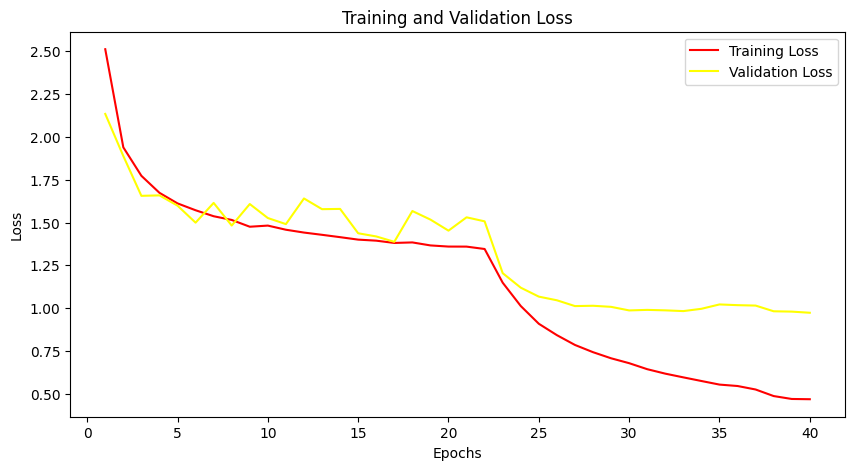

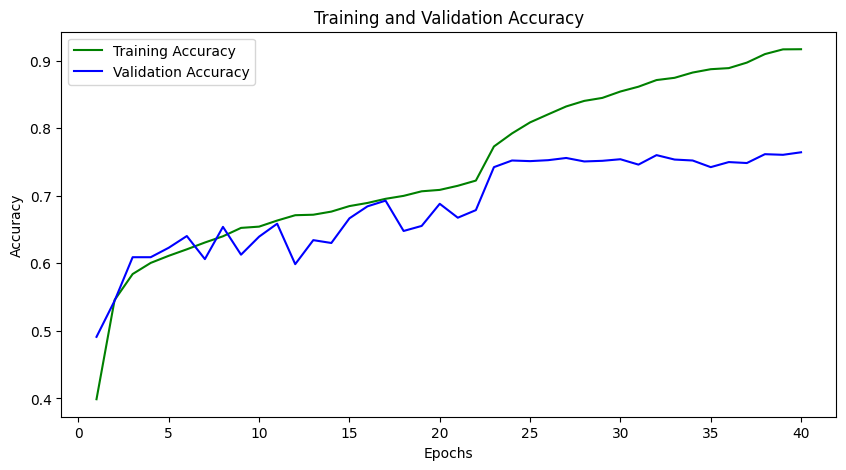

In [17]:
# Plotting
epochs_range = range(1, epochs+1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['loss'], label='Training Loss', color='red')
plt.plot(epochs_range, h.history['val_loss'], label='Validation Loss', color='yellow')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(epochs_range, h.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [14]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [18]:
from keras.models import model_from_json
filepath = "/content/gdrive/MyDrive/Colab Notebooks/"
# Load JSON model architecture
json_file = open(filepath + "model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [ ]:
import numpy as np

# model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)


Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 64ms/step
3202
1/1 [==============================] - 0s 63ms/step
3203
1/1 [==============================] - 0s 81ms/step
3204
1/1 [==============================] - 0s 73ms/step
3205
1/1 [==============================] - 0s 64ms/step
3206
1/1 [==============================] - 0s 67ms/step
3207
1/1 [==============================] - 0s 63ms/step
3208
1/1 [==============================] - 0s 65ms/step
3209
1/1 [==============================] - 0s 71ms/step
3210
1/1 [==============================] - 0s 68ms/step
3211
1/1 [==============================] - 0s 68ms/step
3212
1/1 [==============================] - 0s 67ms/step
3213
1/1 [==============================] - 0s 70ms/step
3214
1/1 [==============================] - 0s 97ms/step
3215
1/1 [==============================] - 0s 110ms/step
3216
1/1 [==============================] - 0s 121ms/step
3217
1/1 [====================

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

NameError: name 'y_true' is not defined

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 47.429%
Mean Recall: 28.326%
Mean Precision: 37.366%
> Cargo plane: Recall: 61.260% Precision: 51.867% Specificity: 98.260% Dice: 56.173%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 90.909% Precision: 57.018% Specificity: 82.794% Dice: 70.081%
> Bus: Recall: 33.735% Precision: 42.790% Specificity: 94.943% Dice: 37.727%
> Truck: Recall: 30.954% Precision: 24.475% Specificity: 85.921% Dice: 27.336%
> Motorboat: Recall: 3.648% Precision: 41.489% Specificity: 99.729% Dice: 6.707%
> Fishing vessel: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Dump truck: Recall: 10.841% Precision: 31.455% Specificity: 98.550% Dice: 16.125%
> Excavator: Recall: 25.349% Precision: 48.544% Specificity: 98.970% Dice: 33.306%
> Building: Recall: 83.152% Precision: 50.755% Specificity: 77.331% Dice: 63.035%
> Storage tank: Recall: 0.068% Precision: 100.000% Specificity: 100.000% Dice: 0.136%
> Shipping container: Re